#  Natural Language Processing: Classification of News Articles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding,
)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# 1. Data preparation
Import data. 

In [2]:
# Importing the dataset. Ww usually have a look at the data. Here we simply show the first 5 rows
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
print(train_data.head(5))

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


Change labels from 1-4 to 0-3

In [3]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

## Preprocessing 

Lowercase descriptions and clean up non-letter characters.

**TODO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.

In [4]:
# Function to preprocess the data
def preprocess_text(string):
    # TODO 1: REMOVE http (html, ...) and news agencies names (Reuters, AP, ...)
    # Removing HTML links and artifacts
    html_pattern = r"http\S+|https\S+|www\.\S+|&quot;|&lt;|&gt;"
    string = re.sub(html_pattern, '', string)

    # Removing news agency names
    news_agency_pattern = r"\bReuters\b|\bAP\b|\bBBC\b|\bUSATODAY.com\b|\bForbes.com\b|\bUSATODAY.com\b|\bPC World\b|\bMacCentral\b|\SPACE.com\b|\bCNN\b|\b&lt;strong&gt;"  # Extend this list as needed
    string = re.sub(news_agency_pattern, '', string)

    string = string.lower()
    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string)
    return string
train_data["Description"] = train_data["Description"].apply(preprocess_text)
test_data["Description"] = test_data["Description"].apply(preprocess_text)

Convert dataframes to lists (needed for further functions).

In [5]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [6]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [14]:
nltk.download("stopwords")
def remove_stopwords(data_list):
    stopword_list = stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### TODO 2: STEMMING
Use **Stemming** or **Lemmatization** to grammatical word variations.

In [22]:
# TODO 2
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Create an instance of PorterStemmer
porter = PorterStemmer()

def stemSentence(string):
    token_words = word_tokenize(string)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Applying the preprocessing to the datasets
train_data["Description"] = train_data["Description"].apply(stemSentence)
test_data["Description"] = test_data["Description"].apply(stemSentence)

## 2. Recurrent Neural Network classifier with Keras and Tensorflow

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [23]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors 
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

(96000, 4)


First we use the TextVectorization layer to convert the text to a sequence of integers.

In [24]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)
# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'new', 'two', 'us', 'quot', 'year', 'first', 'monday', 'wednesday', 'tuesday', 'one', 'thursday', 'company', 'world', 'friday', 'inc', 'u', 'last', 'york', 'yesterday', 'three', 'president', 'week', 'million', 'corp', 'oil', 'sunday', 'time', 'united', 'would', 'today', 'game', 'government', 'people', 'years', 'could', 'second', 'group', 'iraq', 'percent', 'saturday', 'software', 'night', 'season', 'next', 'third', 'prices', 'day', 'security', 'microsoft', 'stocks', 'quarter', 'team', 'minister', 'internet', 'state', 'announced', 'back', 'four', 'international', 'washington', 'high', 'billion', 'market', 'may', 'news', 'former', 'officials', 'business', 'states', 'says', 'top', 'win', 'month', 'n', 'city', 'record', 'country', 'victory', 'end', 'european', 'largest', 'league', 'american', 'reported', 'open', 'afp', 'technology', 'service', 'computer', 'home', 'sales', 'national', 'five', 'prime', 'federal', 'killed', 'according', 'china', 'research', 'bush', 'co',

In [25]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [26]:
# see how a vectorized news description looks like
print(train_data_vectorized[1])

tf.Tensor(
[   1    1    1 1950  634    1    1   23    1    1    1  238  443    7
  526  159   11    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)


We then build a RNN.

We use an *Embedding layer* to convert the integer sequences to embeddings. You can read about how this works [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 96,900
Trainable params: 96,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 45s 48ms/step - loss: 0.4813 - accuracy: 0.8232 - val_loss: 0.3393 - val_accuracy: 0.8838
Epoch 2/5
750/750 [==============================] - 28s 37ms/step - loss: 0.3211 - accuracy: 0.8895 - va

<Axes: >

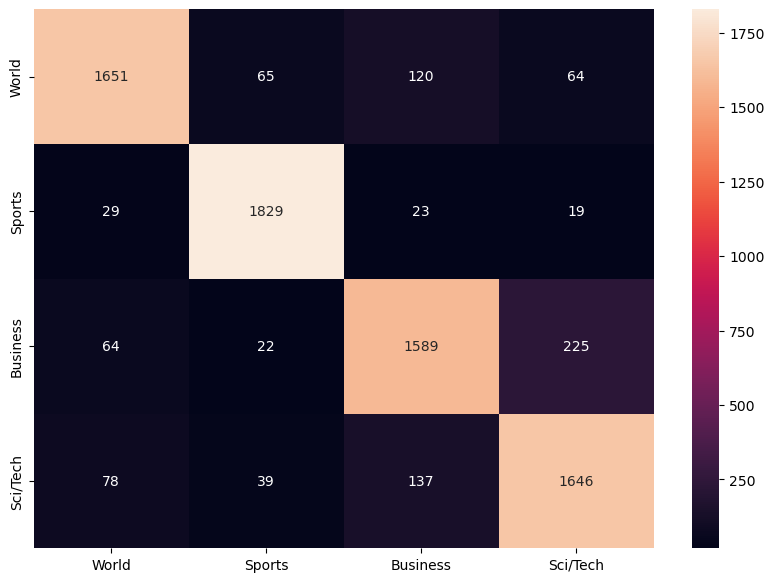

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

# TODO 3: Creating Example Predictions


In [34]:
sample_news = list()
# TODO 3: create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels
# Use one example per class
sample_news.append("Maine's top election official has ruled that Donald Trump cannot run for president next year in the state, citing a constitutional insurrection clause.")
sample_news.append("Real Madrid manager Carlo Ancelotti has signed a new deal with the club which will run until June 2026.")
sample_news.append("House prices have ended the year 1.8% lower, according to Nationwide which forecasts no growth or a further fall in 2024.")
sample_news.append("The robot's basic requirement was to survey an ancient crater lake and to collect rocks that would aid the quest to identify evidence for past life.")
# Also, find one example that gets misclassified and discuss why it might happen in the markdown above.
sample_news.append("Pornhub's parent company has agreed to make payments of $1.8m (£1.42m) to the US government to resolve allegations of profiting from sex trafficking.US officials said Aylo had [turned] a blind eye to reports that women were deceived and coerced into videos appearing on the site.")

# preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# vectorize the sample news
sample_news_vectorized = vectorizer(sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")


1/1 [==============================] - 0s 135ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Business News


## Misclassification in News Classification

In "TODO 3" of my coursework, I observed a misclassification issue with the last sample news piece. The model incorrectly categorized a technology-related article as business news. Reflecting on this, a few key reasons stand out:

### Financial Elements
The article's mention of a $1.8m settlement likely swayed the model, as such financial details are commonly associated with business news.

### Lack of Explicit Tech Terminology
Although the article was about a technology platform, it didn't prominently feature tech-specific language. The focus on legal and financial matters possibly led the model to lean towards a business classification.

### Complex Thematic Nature
The article blended technology, legal, and ethical issues. This complexity could be challenging for the model if its training predominantly involved more straightforward, singularly themed articles.


## TODO 4: Create a new model [2]

Epoch 1/5
750/750 [==============================] - 15s 18ms/step - loss: 0.4586 - accuracy: 0.8320 - val_loss: 0.3392 - val_accuracy: 0.8829
Epoch 2/5
750/750 [==============================] - 14s 18ms/step - loss: 0.3155 - accuracy: 0.8888 - val_loss: 0.3330 - val_accuracy: 0.8832
Epoch 3/5
750/750 [==============================] - 12s 15ms/step - loss: 0.2871 - accuracy: 0.8977 - val_loss: 0.3312 - val_accuracy: 0.8839
Epoch 4/5
750/750 [==============================] - 13s 17ms/step - loss: 0.2537 - accuracy: 0.9110 - val_loss: 0.3371 - val_accuracy: 0.8832
Epoch 5/5
238/238 [==============================] - 1s 4ms/step
Test Set Accuracy:  0.8747368421052631


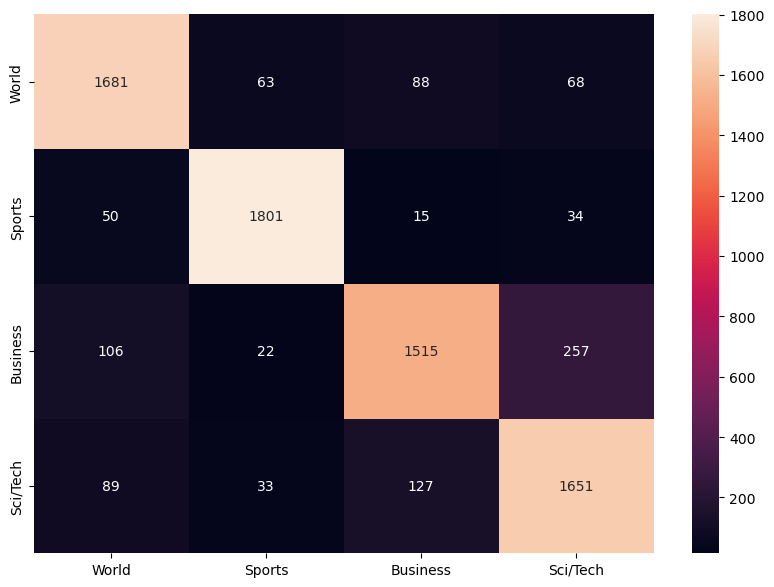

In [35]:
# TODO 4
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.metrics import Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels)
)

# Predict the labels on the test data
cnn_predictions = model.predict(test_data_vectorized)
# Convert predictions to int labels
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy: ", accuracy)

# Create a confusion matrix
cm = confusion_matrix(test_labels_list, cnn_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.show()


## Analysis of Preprocessing Steps and Model Architectures

### To Do 1: Removing HTML Code and News Agency Names

**Observation**: After these preprocessing steps, the accuracy of our LSTM model slightly decreased from 0.8876 to 0.8836.

**Discussion**: These steps aimed to clean the data by removing elements that were presumed to be irrelevant or noise, such as HTML tags and news agency names. The initial assumption might be that removing such noise should enhance model performance by focusing on more relevant text features. However, the slight decrease in accuracy suggests two possibilities:

1. **Contextual Loss**: News agency names could carry contextual significance, potentially offering stylistic or thematic cues that the model was exploiting. Their removal, therefore, might have stripped away some useful information.

2. **Generalization vs. Overfitting**: A higher accuracy with 'noisier' data could indicate overfitting, where the model learns patterns specific to the training data that don't generalize well. While the reduced accuracy seems negative, it might suggest that the model is now relying less on these specific cues and potentially generalizing better.

### To Do 2: Applying Stemming

**Observation**: The application of stemming improved the accuracy to 0.8897.

**Discussion**: Stemming reduces words to their base or root form, which helps in consolidating the different variations of a word into a single, standard form. This process can aid the model in focusing on the essence of the word rather than its syntactical variations, leading to a more generalized understanding of the text. The improvement in accuracy indicates that this consolidation of word forms likely helped the model in making more accurate predictions by focusing on the core meaning of words.

### To Do 4: Changing the Model to a 1D CNN

**Observation**: Switching to a 1D CNN model yielded an accuracy of 0.8805, which is slightly lower than the LSTM model with stemming.

**Discussion**: CNNs, being adept at capturing spatial hierarchies in data, are generally more efficient in processing data where local patterns are more significant (such as in image recognition tasks). In text analysis, however, the performance of CNNs can vary depending on the nature of the dataset and the task. 

1. **Local vs. Sequential Dependencies**: CNNs might not capture long-term dependencies and sequential context in text as effectively as LSTMs, which could explain the slight drop in performance.

2. **Model Complexity and Task Suitability**: The specific architecture of the CNN (number of layers, filter sizes, etc.) plays a crucial role. It’s possible that the chosen architecture was not optimal for this task, or that LSTM's ability to capture sequential information in text is more suited for this particular dataset and task. [3]

### Overall Implications for Model Development

The steps undertaken provide valuable insights into how different preprocessing techniques and model architectures can impact performance. The key takeaway is that while certain standard practices (like data cleaning and noise reduction) are generally beneficial, their impact can vary depending on the dataset and the problem context. Similarly, the choice of model architecture must align with the nature of the data and the specific requirements of the task. It’s also crucial to consider a range of performance metrics and not rely solely on accuracy, especially in cases of class imbalances or when other aspects of model performance (like precision or recall) are critical.

This iterative process of experimenting with data preprocessing and model architectures is central to developing effective machine learning models. It underscores the importance of understanding both the data and the models to make informed decisions that enhance model performance and generalizability.
